<a href="https://colab.research.google.com/github/sflin/SchneewittchensStiefmutter/blob/master/Ktrain_TripletExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Gdrive for data access

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import and installation

In [0]:
!pip install ktrain

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [0]:
# disable tensorflow v2-behaviour when training a bilstm-crf network!
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

In [0]:
import ktrain
import pandas as pd
import re
from ktrain import text
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

# 1. Data-Collection

Choose between small (\~15'000 samples), medium (\~50'000 samples) and big dataset (\~100'000 samples)

In [0]:
path = '/content/drive/My Drive/MT/data/df-triplets-small.parquet.gzip' # small
#path = '/content/drive/My Drive/MT/data/df-triplets-medium.parquet.gzip' # medium
#path = '/content/drive/My Drive/MT/data/df-triplets.parquet.gzip' # large
df = pd.read_parquet(path)
df = df[['object_id','cindex','context']]

# 2. Pre-Processing

Pre-Process and encode input text and triplets:

In [0]:
def replace(tokens, repl, context, pattern):
  """ Replaces specific pattern in context string.
  :param tokens: array_like, list for number of tokens to replace
  :param repl: str, part of replacement; either OBJ, REL or VAL 
  :param context: str
  :param pattern: str, specific pattern which should be replaced
  :return str: the context string with the pattern replaced"""

  repl_length = len(tokens) -1
  b_tag = 'B-' + repl + ' '
  i_tag = 'I-' + repl + ' '
  replacement = (b_tag + (repl_length * i_tag).strip()).strip() 
  return context.replace(pattern, replacement)

def split_tokens(sequence):
  """ Splits a sequence into tokens.
  :param sequence: str
  :return tmp: array_like, list of tokens"""

  sequence = sequence.split(' ')
  symbols = ['?','!','%','-','"','.',':',';', ',', '(',')','*']
  tmp = []
  for i in sequence:
    if i:
      if len(i) > 1 and i[0] in symbols and i[-1] in symbols:
        tmp.append(i[0])
        tmp.append(i[1:-1])
        tmp.append(i[-1])
      elif i[-1] in symbols:
        tmp.append(i[:-1])
        tmp.append(i[-1])
      elif i[0] in symbols:
        tmp.append(i[0])
        tmp.append(i[1:])
      else:
        tmp.append(i)
  tmp = [t for t in tmp if t]
  return tmp

def encode_output(triplets, sent):
  """Finds the triplets in a sentence and encodes it in the BIO-format. 
  :param triplets: str, contains object, relation and value
  :param sent: str, a sentence
  :return input_tokens: array_like
  :return output_tokens: array_like"""

  sent = sent.replace(' ||| ', ' ') 
  sent = sent.replace('\\', '')
  sent = sent.replace(',*', ', *')
  input_tokens = split_tokens(sent)
  input_tokens = [t for t in input_tokens if t]
  tr = triplets
  triplets = triplets.split('||')
  triplets = [t.strip() for t in triplets]
  rel = triplets[1]
  multi_rels = False
  if '.*' in rel:
    rel = rel.split('\\b.*')
    multi_rels = True
  else:
    rel = rel.replace('\\','')
    triplets[1] = rel
    if len(rel) > 1:
      rel = split_tokens(rel)
  obj = split_tokens(triplets[0])
  val = split_tokens(triplets[2])
  output_tokens = sent
  if len(triplets[0]) > len(triplets[2]):
    output_tokens = replace(obj, 'obj', output_tokens, triplets[0])
    output_tokens = replace(val, 'val', output_tokens, triplets[2]) 
  else:
    output_tokens = replace(val, 'val', output_tokens, triplets[2]) 
    output_tokens = replace(obj, 'obj', output_tokens, triplets[0])
  if multi_rels:
    output_tokens = replace([rel[0]], 'rel', output_tokens, rel[0])
    output_tokens = replace([rel[1]], 'rel', output_tokens, rel[1])
  else:
    output_tokens = replace(rel, 'rel', output_tokens, triplets[1])
  output_tokens = split_tokens(output_tokens)
  words = ['B-obj', 'I-obj','B-rel','I-rel','B-val','I-val','O']
  output_tokens = [t if t in words else 'O' for t in output_tokens ]
  if len(input_tokens) != len(output_tokens):
    return input_tokens, None
  return input_tokens, output_tokens

def encode(row):
  input_sequence, output_seq = encode_output(row['cindex'], row['context'])
  return input_sequence, output_seq

In [0]:
enc_df = df[['context','cindex']]
enc_df['encoded'] = enc_df.apply(encode, axis=1)
df2 = pd.DataFrame(enc_df['encoded'].to_list(), columns=['context','triplets'])
print(df2.head())
df2 = pd.concat([df2, df[['object_id']]], axis=1)

                                             context                                           triplets
0  [Norwegen, liegt, damit, im, oberen, Drittel, ...  [B-obj, O, O, O, O, O, O, O, O, O, O, O, O, O,...
1  [Nach, Angaben, des, staatlichen, Statistische...  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
2  [(, *, 22, ., Februar, 1732, auf, dem, Gutshof...  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
3  [George, Washington, (, *, 22, ., Februar, 173...  [B-obj, I-obj, O, O, O, O, O, O, O, O, O, O, O...
4  [George, Washington, (, *, 22, ., Februar, 173...  [O, B-obj, O, O, O, O, O, O, O, O, O, O, O, O,...


In [0]:
# Split and pad train and test sets
df2 = df2.dropna()
gb = df2.groupby('object_id')
gr = [gb.get_group(x) for x in gb.groups]
train, test = train_test_split(gr, test_size = 0.25)
train = pd.concat(train)
test = pd.concat(test)
x_train, y_train = train['context'], train['triplets']
x_test, y_test = test['context'], test['triplets']
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

In [0]:
(trn, val, preproc) = text.entities_from_array(x_train, y_train, x_test, y_test)

training data sample:
   SentenceID        Word Tag
0           0         Die   O
1           0  Hauptstadt   O
2           0         des   O
3           0     Bezirks   O
4           0         ist   O
validation data sample:
   SentenceID     Word    Tag
0           0  Philipp  B-obj
1           0   Rösler  I-obj
2           0        (      O
3           0        *  B-rel
4           0       24  B-val
Number of sentences:  13582
Number of words in the dataset:  52237
Tags: ['I-obj', 'O', 'I-rel', 'B-obj', 'B-rel', 'I-val', 'B-val']
Number of Labels:  7
Longest sentence: 764 words


# 3. Model Building

Choose between Bi-LSTM-CRF model...

In [0]:
#bilstm model
WV_URL ='https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz'
model = text.sequence_tagger('bilstm-crf', preproc, wv_path_or_url=WV_URL)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, None, None)] 0                                            
__________________________________________________________________________________________________
word_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, None, None, 2 2375        char_input[0][0]                 
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, None, 300)    17365200    word_input[0][0]                 
______________________________________________________________________________________________

... and Bi-LSTM BERT model

In [0]:
WV_URL ='https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.vec.gz'
model = text.sequence_tagger('bilstm-bert', preproc, bert_model = 'bert-base-german-cased', wv_path_or_url=WV_URL)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, None, 300)    25755600    word_input[0][0]                 
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None, 768)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1068)   0           word_embedding[0][0]             
                                                                 input_1[0][0]                

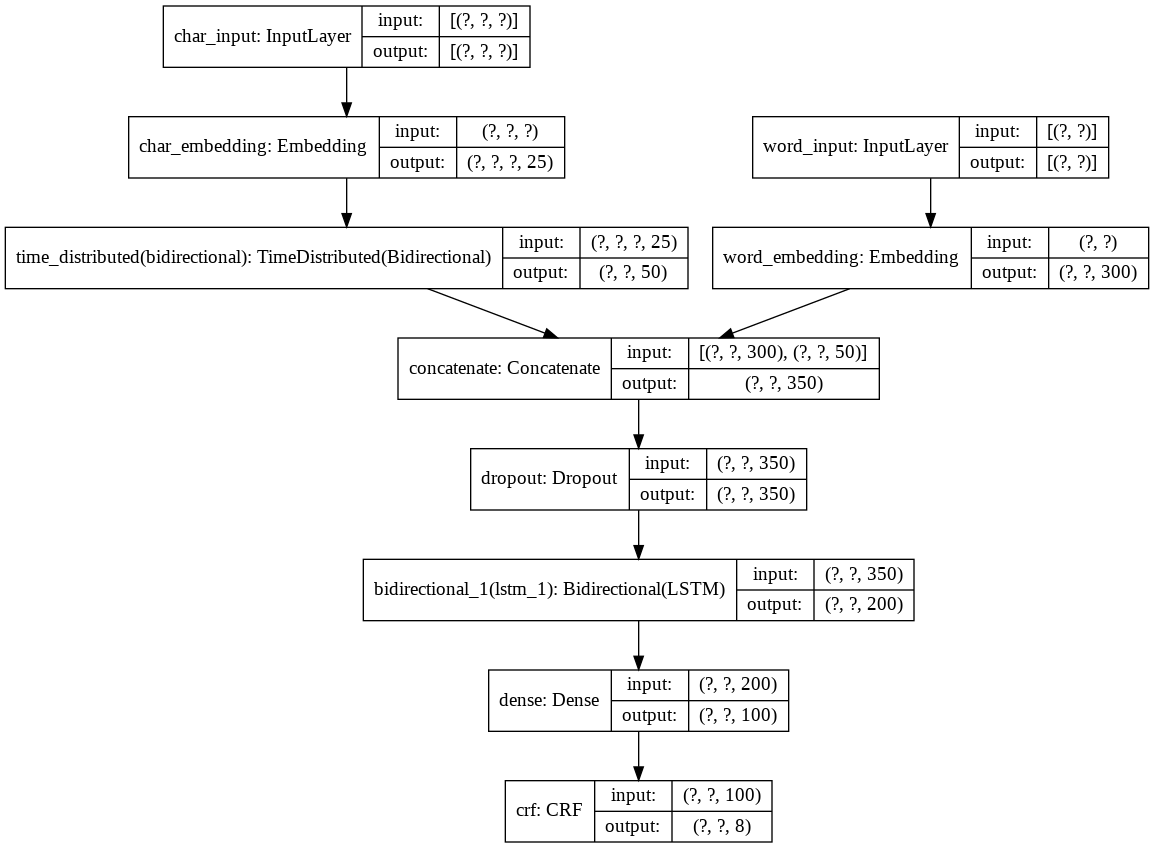

In [0]:
# bilstm-crf model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

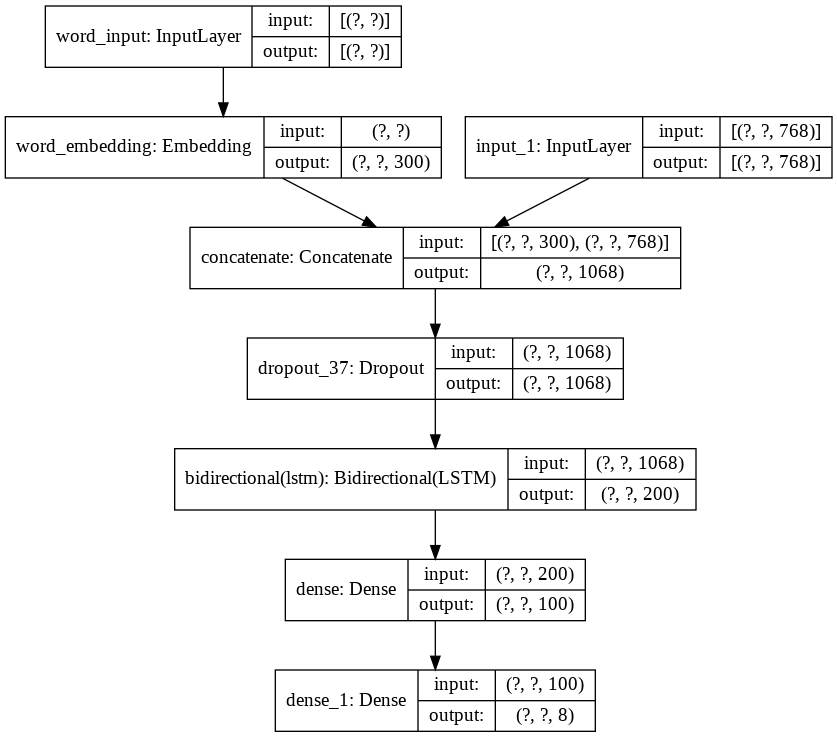

In [0]:
# bert-model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [0]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=64)

In [0]:
# training for 10 epochs using a learning rate of 0.001 (Keras default for Adam optmizer)
learner.fit(1e-3, 10, cycle_len=1, checkpoint_folder='/content/drive/My Drive/MT/save/saved_weights') 
#learner.autofit(1e-3, checkpoint_folder='/content/drive/My Drive/MT/save/saved_weights9')

Train for 215 steps, validate for 142 steps
Epoch 1/10
215/215 [==============================] - 250s 1s/step - loss: 0.0837 - val_loss: 0.0646
Epoch 2/10
215/215 [==============================] - 251s 1s/step - loss: 0.0536 - val_loss: 0.0575
Epoch 3/10
215/215 [==============================] - 252s 1s/step - loss: 0.0480 - val_loss: 0.0555
Epoch 4/10
215/215 [==============================] - 251s 1s/step - loss: 0.0439 - val_loss: 0.0546
Epoch 5/10
215/215 [==============================] - 249s 1s/step - loss: 0.0412 - val_loss: 0.0542
Epoch 6/10
215/215 [==============================] - 248s 1s/step - loss: 0.0389 - val_loss: 0.0535
Epoch 7/10
215/215 [==============================] - 248s 1s/step - loss: 0.0365 - val_loss: 0.0531
Epoch 8/10
215/215 [==============================] - 248s 1s/step - loss: 0.0349 - val_loss: 0.0529
Epoch 9/10
215/215 [==============================] - 248s 1s/step - loss: 0.0335 - val_loss: 0.0530
Epoch 10/10
215/215 [==========================

In [0]:
# load the weights of the best performing layer 
learner.model.load_weights('/content/drive/My Drive/MT/save/saved_weights/weights-08.hdf5')

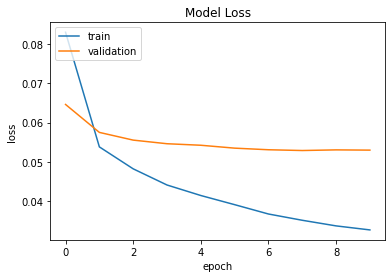

In [0]:
# plot loss
learner.plot()

In [0]:
# bilstm-crf
learner.validate(class_names = preproc.get_classes())

   F1: 69.91
           precision    recall  f1-score   support

      obj       0.58      0.49      0.53      5951
      rel       0.74      0.90      0.81      5015
      val       0.68      0.87      0.76      4169

micro avg       0.67      0.73      0.70     15135
macro avg       0.66      0.73      0.69     15135



0.6991422150476372

In [0]:
# generate a predictor
predictor = ktrain.get_predictor(learner.model, preproc)

In [0]:
predictor.predict('Pjotr Iljitsch Tschaikowski ( * 25. April 1840 in Kamsko-Wotkinski Sawod, Russisches Kaiserreich , † 25. Oktober 1893 in Sankt Petersburg, Russisches Kaiserreich), deutsch Peter Tschaikowsky oder Tschaikowski, war ein russischer Komponist.')

[('Pjotr', 'B-obj'),
 ('Iljitsch', 'I-obj'),
 ('Tschaikowski', 'I-obj'),
 ('(', 'O'),
 ('*', 'B-rel'),
 ('25', 'O'),
 ('.', 'I-val'),
 ('April', 'O'),
 ('1840', 'I-val'),
 ('in', 'O'),
 ('Kamsko', 'O'),
 ('-', 'O'),
 ('Wotkinski', 'O'),
 ('Sawod', 'O'),
 (',', 'O'),
 ('Russisches', 'O'),
 ('Kaiserreich', 'O'),
 (',', 'O'),
 ('†', 'O'),
 ('25', 'B-val'),
 ('.', 'I-val'),
 ('Oktober', 'O'),
 ('1893', 'O'),
 ('in', 'O'),
 ('Sankt', 'O'),
 ('Petersburg', 'O'),
 (',', 'O'),
 ('Russisches', 'O'),
 ('Kaiserreich', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('deutsch', 'O'),
 ('Peter', 'O'),
 ('Tschaikowsky', 'O'),
 ('oder', 'O'),
 ('Tschaikowski', 'O'),
 (',', 'O'),
 ('war', 'O'),
 ('ein', 'O'),
 ('russischer', 'O'),
 ('Komponist', 'O'),
 ('.', 'O')]

In [0]:
# store predictor to disk
predictor.save('/content/drive/My Drive/MT/predictor/predictor')